In [14]:
pip install pandas numpy matplotlib scikit-learn seaborn
pip install scikit-fuzzy


Note: you may need to restart the kernel to use updated packages.


In [2]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler

df = pd.read_csv( "WHO-COVID-19-global-data.csv", sep=";", na_values=["", " "], engine="python" )
df.info()

country_region_map = (
    df.dropna(subset=['WHO_region'])
      .groupby('Country')['WHO_region']
      .agg(lambda x: x.value_counts().index[0])
      .to_dict()
)

df['WHO_region'] = df['WHO_region'].fillna(df['Country'].map(country_region_map))

df['WHO_region'] = df['WHO_region'].fillna("Unknown")

df['Date_reported'] = pd.to_datetime(df['Date_reported'], errors='coerce')
df = df.dropna(subset=['Date_reported'])

df['Cases_diff'] = df.groupby('Country')['Cumulative_cases'].diff()
df['Deaths_diff'] = df.groupby('Country')['Cumulative_deaths'].diff()

df['New_cases'] = df['New_cases'].fillna(df['Cases_diff'])
df['New_deaths'] = df['New_deaths'].fillna(df['Deaths_diff'])

df[['New_cases', 'New_deaths']] = df[['New_cases', 'New_deaths']].fillna(0)

df[['New_cases', 'New_deaths']] = df[['New_cases', 'New_deaths']].clip(lower=0)

df['YearMonth'] = df['Date_reported'].dt.to_period('M').dt.to_timestamp()

monthly_df = df.groupby(['Country', 'YearMonth']).agg({
    'New_cases': 'sum',
    'New_deaths': 'sum',
    'Cumulative_cases': 'max',
    'Cumulative_deaths': 'max'
}).reset_index()

monthly_df = monthly_df.merge(
    df[['Country', 'WHO_region']].drop_duplicates(subset=['Country']),
    on='Country',
    how='left'
)


monthly_df['Death_rate'] = monthly_df['New_deaths'] / (monthly_df['New_cases'] + 1)

monthly_df['Case_growth_rate'] = (
    monthly_df.groupby('Country')['Cumulative_cases'].diff().fillna(0)
)

monthly_df['Case_growth_rate'] = monthly_df['Case_growth_rate'].clip(lower=0)

monthly_df.replace([np.inf, -np.inf], np.nan, inplace=True)

flow_cols = ['New_cases', 'New_deaths', 'Death_rate', 'Case_growth_rate']

for col in flow_cols:
    Q1 = monthly_df[col].quantile(0.25)
    Q3 = monthly_df[col].quantile(0.75)
    IQR = Q3 - Q1
    lower = Q1 - 1.5 * IQR
    upper = Q3 + 1.5 * IQR
    monthly_df[col] = np.clip(monthly_df[col], lower, upper)

scale_cols = ['New_cases', 'New_deaths', 'Cumulative_cases', 
              'Cumulative_deaths', 'Death_rate', 'Case_growth_rate']

scaler = MinMaxScaler()
monthly_df[scale_cols] = scaler.fit_transform(monthly_df[scale_cols])

monthly_df.to_csv("covid_clean_preprocessed_for_fcm.csv", index=False)

print("✅ COVID dataset cleaned & prepared for FCM clustering")
monthly_df.head()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 57840 entries, 0 to 57839
Data columns (total 8 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Date_reported      57840 non-null  object 
 1   Country_code       57599 non-null  object 
 2   Country            57840 non-null  object 
 3   WHO_region         53502 non-null  object 
 4   New_cases          39028 non-null  float64
 5   Cumulative_cases   57840 non-null  int64  
 6   New_deaths         25001 non-null  float64
 7   Cumulative_deaths  57840 non-null  int64  
dtypes: float64(2), int64(2), object(4)
memory usage: 3.5+ MB
✅ COVID dataset cleaned & prepared for FCM clustering


,Country,YearMonth,New_cases,New_deaths,Cumulative_cases,Cumulative_deaths,WHO_region,Death_rate,Case_growth_rate
0,Afghanistan,2020-01-01,0.108675,0.400,0.000400,0.001286,EMRO,0.983012,0.0
1,Afghanistan,2020-02-01,0.111318,0.592,0.000355,0.001074,EMRO,1.000000,0.0
2,Afghanistan,2020-03-01,0.138899,0.336,0.000021,0.000054,EMRO,0.646266,0.0
3,Afghanistan,2020-04-01,0.017342,0.144,0.000380,0.001224,EMRO,1.000000,1.0
4,Afghanistan,2020-05-01,0.369792,1.000,0.000316,0.000692,EMRO,1.000000,0.0


In [3]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler

df = pd.read_csv( "WHO-COVID-19-global-data.csv", sep=";", na_values=["", " "], engine="python" )
df.info()
print("Number of missing values per column")
print(df.isnull().sum())

print("Percentage of missing values per column")
print((df.isnull().mean() * 100).round(2))

df.describe(include='all')


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 57840 entries, 0 to 57839
Data columns (total 8 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Date_reported      57840 non-null  object 
 1   Country_code       57599 non-null  object 
 2   Country            57840 non-null  object 
 3   WHO_region         53502 non-null  object 
 4   New_cases          39028 non-null  float64
 5   Cumulative_cases   57840 non-null  int64  
 6   New_deaths         25001 non-null  float64
 7   Cumulative_deaths  57840 non-null  int64  
dtypes: float64(2), int64(2), object(4)
memory usage: 3.5+ MB
Number of missing values per column
Date_reported            0
Country_code           241
Country                  0
WHO_region            4338
New_cases            18812
Cumulative_cases         0
New_deaths           32839
Cumulative_deaths        0
dtype: int64
Percentage of missing values per column
Date_reported         0.00
Country_code      

,Date_reported,Country_code,Country,WHO_region,New_cases,Cumulative_cases,New_deaths,Cumulative_deaths
count,57840,57599,57840,53502,3.902800e+04,5.784000e+04,25001.000000,5.784000e+04
unique,241,239,240,7,NaN,NaN,NaN,NaN
top,05/01/2020,AF,Afghanistan,EURO,NaN,NaN,NaN,NaN
freq,240,241,241,13255,NaN,NaN,NaN,NaN
mean,NaN,NaN,NaN,NaN,1.988104e+04,1.792594e+06,282.323947,2.001023e+04
std,NaN,NaN,NaN,NaN,2.707823e+05,7.797691e+06,1214.392195,8.186440e+04
min,NaN,NaN,NaN,NaN,-6.507900e+04,0.000000e+00,-3432.000000,0.000000e+00
25%,NaN,NaN,NaN,NaN,4.300000e+01,4.162750e+03,4.000000,2.800000e+01
50%,NaN,NaN,NaN,NaN,3.930000e+02,4.588300e+04,20.000000,5.650000e+02
75%,NaN,NaN,NaN,NaN,3.968000e+03,5.220872e+05,105.000000,6.974500e+03


In [1]:
!pip install scikit-fuzzy


Clusters: 3, Fuzziness (m): 2, FPC: 0.7319
Clusters: 4, Fuzziness (m): 2, FPC: 0.7347
Clusters: 5, Fuzziness (m): 2, FPC: 0.7567
Clusters: 6, Fuzziness (m): 2, FPC: 0.7338
Clusters: 7, Fuzziness (m): 2, FPC: 0.7140
Clusters: 3, Fuzziness (m): 1.9, FPC: 0.7512
Clusters: 4, Fuzziness (m): 1.9, FPC: 0.7582
Clusters: 5, Fuzziness (m): 1.9, FPC: 0.7834
Clusters: 6, Fuzziness (m): 1.9, FPC: 0.7635
Clusters: 7, Fuzziness (m): 1.9, FPC: 0.7369
Clusters: 3, Fuzziness (m): 1.8, FPC: 0.7718
Clusters: 4, Fuzziness (m): 1.8, FPC: 0.7827
Clusters: 5, Fuzziness (m): 1.8, FPC: 0.8108
Clusters: 6, Fuzziness (m): 1.8, FPC: 0.7940
Clusters: 7, Fuzziness (m): 1.8, FPC: 0.7674
Clusters: 3, Fuzziness (m): 1.7, FPC: 0.7944
Clusters: 4, Fuzziness (m): 1.7, FPC: 0.8081
Clusters: 5, Fuzziness (m): 1.7, FPC: 0.8387
Clusters: 6, Fuzziness (m): 1.7, FPC: 0.8249
Clusters: 7, Fuzziness (m): 1.7, FPC: 0.7952
Clusters: 3, Fuzziness (m): 1.6, FPC: 0.8196
Clusters: 4, Fuzziness (m): 1.6, FPC: 0.8346
Clusters: 5, Fuzzine

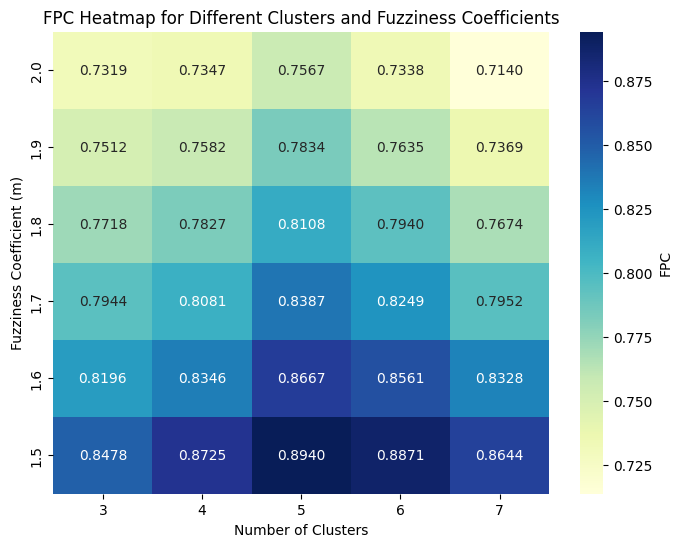

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import skfuzzy as fuzz

monthly_df = pd.read_csv("covid_clean_preprocessed_for_fcm.csv")

features = ['New_cases', 'New_deaths', 'Cumulative_cases',
            'Cumulative_deaths', 'Death_rate', 'Case_growth_rate']

data = monthly_df[features].T  

m_values = [2, 1.9, 1.8, 1.7, 1.6, 1.5]
cluster_counts = [3, 4, 5, 6, 7]

results = []

for m in m_values:
    for c in cluster_counts:
        cntr, u, u0, d, jm, p, fpc = fuzz.cluster.cmeans(
            data=data,
            c=c,
            m=m,
            error=0.005,
            maxiter=1000,
            init=None
        )
        print(f"Clusters: {c}, Fuzziness (m): {m}, FPC: {fpc:.4f}")
        results.append({'Clusters': c, 'Fuzziness': m, 'FPC': fpc})

results_df = pd.DataFrame(results)

heatmap_data = results_df.pivot(index='Fuzziness', columns='Clusters', values='FPC')

plt.figure(figsize=(8,6))
sns.heatmap(heatmap_data, annot=True, fmt=".4f", cmap='YlGnBu', cbar_kws={'label': 'FPC'})
plt.title('FPC Heatmap for Different Clusters and Fuzziness Coefficients')
plt.xlabel('Number of Clusters')
plt.ylabel('Fuzziness Coefficient (m)')
plt.gca().invert_yaxis() 
plt.show()


Fuzzy Partition Coefficient (FPC): 0.894


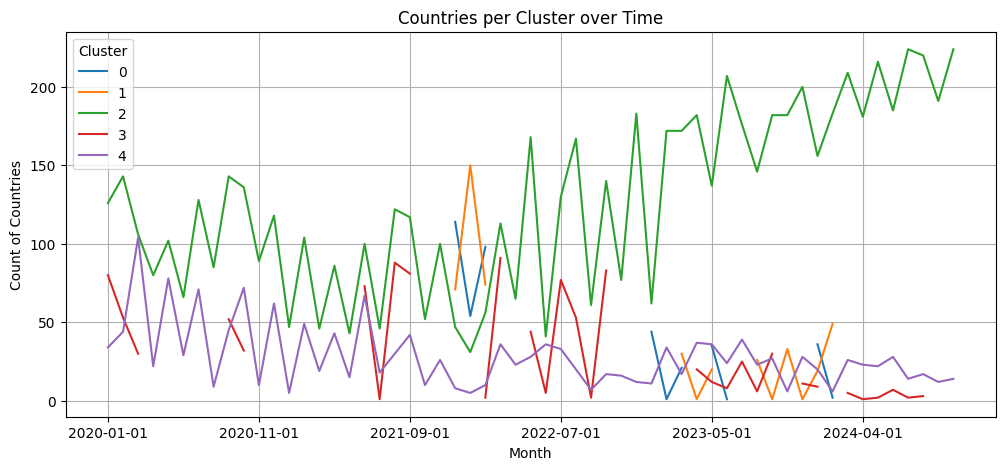

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import skfuzzy as fuzz
from sklearn.preprocessing import MinMaxScaler

monthly_df = pd.read_csv("covid_clean_preprocessed_for_fcm.csv")
monthly_df.head()

features = ['New_cases', 'New_deaths', 'Cumulative_cases',
            'Cumulative_deaths', 'Death_rate', 'Case_growth_rate']

data = monthly_df[features].T 

c = 5

cntr, u, u0, d, jm, p, fpc = fuzz.cluster.cmeans(
    data=data,
    c=c,
    m=1.5,             
    error=0.005,      
    maxiter=1000,
    init=None
)

print("Fuzzy Partition Coefficient (FPC):", round(fpc, 4))

cluster_labels = np.argmax(u, axis=0)
monthly_df['Cluster'] = cluster_labels

for i in range(c):
    monthly_df[f'Cluster_{i}_membership'] = u[i]
    
monthly_df.head()

cluster_time = monthly_df.groupby(['YearMonth', 'Cluster'])['Country'].count().unstack()

cluster_time.plot(figsize=(12,5))
plt.title("Countries per Cluster over Time")
plt.xlabel("Month")
plt.ylabel("Count of Countries")
plt.legend(title="Cluster")
plt.grid(True)
plt.show()



In [3]:

for i in range(c):
    print(f"\n Cluster {i}")
    display(
        monthly_df.groupby('Country')[f'Cluster_{i}_membership']
                  .mean()
                  .sort_values(ascending=False)
                  .head(10)
    )

centers = pd.DataFrame(cntr, columns=features)
centers


 Cluster 0


Country
Russian Federation                                      0.443354
Italy                                                   0.437393
Canada                                                  0.429833
Portugal                                                0.425798
Chile                                                   0.417501
Greece                                                  0.413916
Poland                                                  0.408755
United Kingdom of Great Britain and Northern Ireland    0.407794
Romania                                                 0.385618
Australia                                               0.374610
Name: Cluster_0_membership, dtype: float64


 Cluster 1


Country
Luxembourg                          0.354151
Brunei Darussalam                   0.344593
Afghanistan                         0.300989
French Guiana                       0.287949
Malta                               0.282227
Qatar                               0.276877
Zambia                              0.262787
Democratic Republic of the Congo    0.260877
Maldives                            0.258937
Bahrain                             0.257842
Name: Cluster_1_membership, dtype: float64


 Cluster 2


Country
Tokelau                                       0.999974
International commercial vessel               0.999973
Holy See                                      0.999973
Pitcairn                                      0.999973
International conveyance (Vanuatu)            0.999973
International conveyance (Solomon Islands)    0.999973
International conveyance (American Samoa)     0.999973
International conveyance (Kiribati)           0.999973
Democratic People's Republic of Korea         0.999973
Turkmenistan                                  0.999973
Name: Cluster_2_membership, dtype: float64


 Cluster 3


Country
Russian Federation                                      0.526068
United Kingdom of Great Britain and Northern Ireland    0.440357
United States of America                                0.433047
Mexico                                                  0.430808
Italy                                                   0.423423
Brazil                                                  0.423270
Spain                                                   0.420380
Chile                                                   0.419795
Peru                                                    0.413104
India                                                   0.404771
Name: Cluster_3_membership, dtype: float64


 Cluster 4


Country
Yemen                     0.470787
Jamaica                   0.454516
Sudan                     0.424624
Bosnia and Herzegovina    0.412714
Mali                      0.399018
Guyana                    0.377716
Sri Lanka                 0.375112
Zimbabwe                  0.373805
Slovenia                  0.347362
Chad                      0.339099
Name: Cluster_4_membership, dtype: float64

,New_cases,New_deaths,Cumulative_cases,Cumulative_deaths,Death_rate,Case_growth_rate
0,0.928115,0.926707,0.044997,0.046168,0.370545,0.987352
1,0.193172,0.122852,0.010804,0.009310,0.225573,0.936438
2,0.032929,0.013811,0.007142,0.005661,0.034895,0.019836
3,0.912638,0.906692,0.045043,0.048734,0.412658,0.015018
4,0.053884,0.181472,0.009647,0.010483,0.868594,0.067986


Fuzzy Partition Coefficient (FPC): 0.894


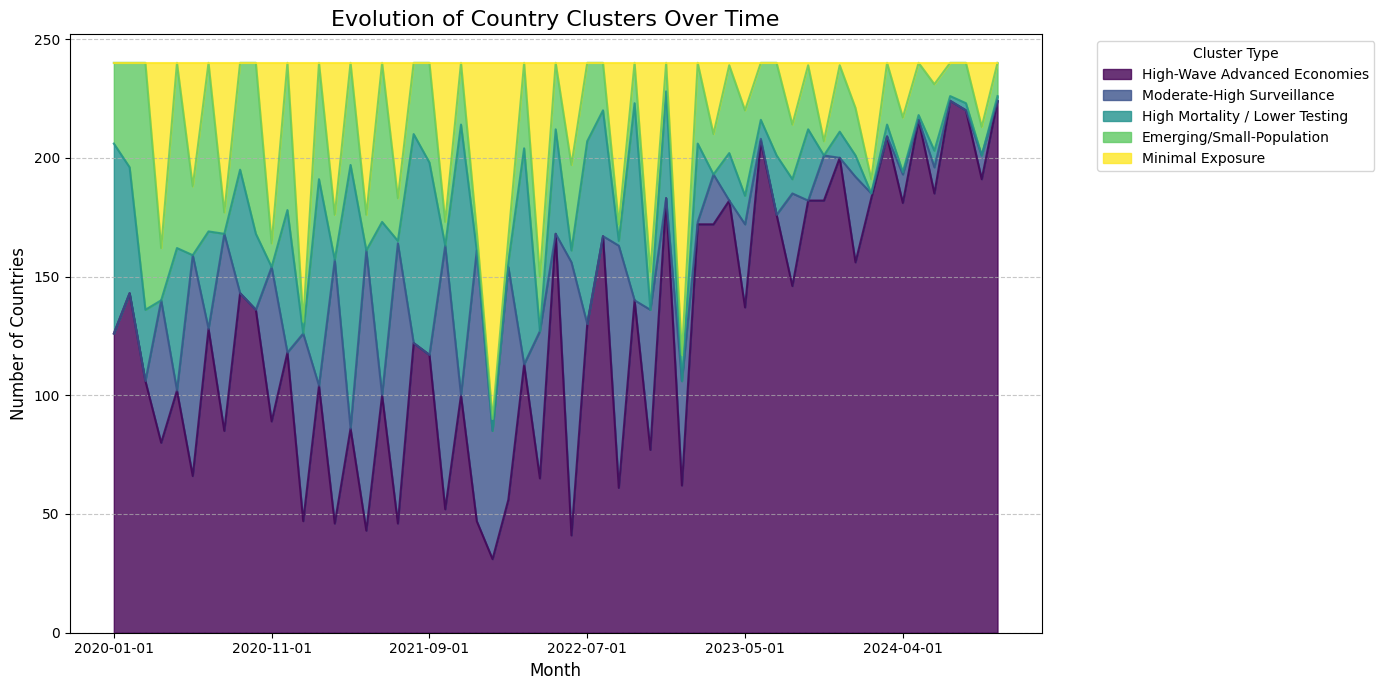


Generating Cluster Profile Heatmap...


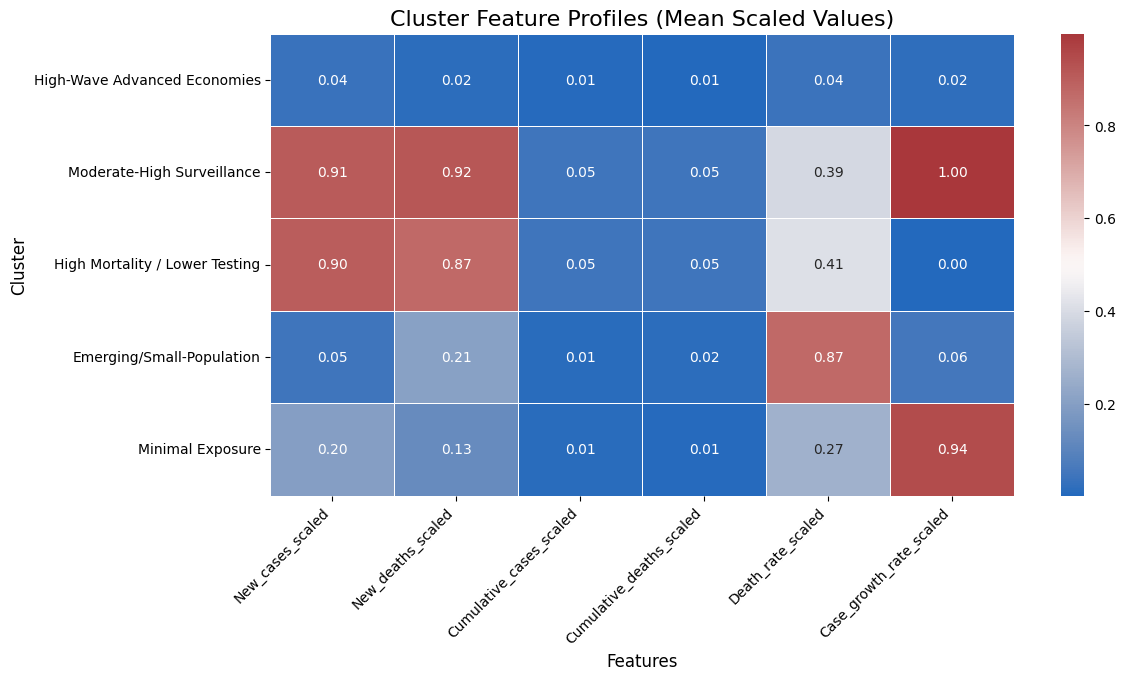

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns 
import skfuzzy as fuzz
from sklearn.preprocessing import MinMaxScaler

try:
    monthly_df = pd.read_csv("covid_clean_preprocessed_for_fcm.csv")
except FileNotFoundError:
    print("Warning: Data file not found. Using dummy data for demonstration.")
    dates = pd.date_range('2020-01', '2022-12', freq='MS')
    countries = [f'Country_{i}' for i in range(100)]
    index = pd.MultiIndex.from_product([dates, countries], names=['Date', 'Country'])
    monthly_df = pd.DataFrame(index=index).reset_index()
    monthly_df['YearMonth'] = monthly_df['Date'].dt.to_period('M').astype(str)
    monthly_df['New_cases'] = np.abs(np.random.randn(len(monthly_df))) * 1e6
    monthly_df['New_deaths'] = monthly_df['New_cases'] * np.random.rand(len(monthly_df)) * 0.05
    monthly_df['Cumulative_cases'] = monthly_df.groupby('Country')['New_cases'].cumsum()
    monthly_df['Cumulative_deaths'] = monthly_df.groupby('Country')['New_deaths'].cumsum()
    monthly_df['Death_rate'] = monthly_df['Cumulative_deaths'] / monthly_df['Cumulative_cases']
    monthly_df['Case_growth_rate'] = monthly_df.groupby('Country')['New_cases'].pct_change().fillna(0)
    monthly_df = monthly_df.fillna(0).replace([np.inf, -np.inf], 0)


features = ['New_cases', 'New_deaths', 'Cumulative_cases',
            'Cumulative_deaths', 'Death_rate', 'Case_growth_rate']

scaler = MinMaxScaler()
data_scaled = scaler.fit_transform(monthly_df[features].fillna(0))

data_scaled_T = data_scaled.T

c = 5 
cntr, u, u0, d, jm, p, fpc = fuzz.cluster.cmeans(
    data=data_scaled_T,
    c=c,
    m=1.5,          
    error=0.005,      
    maxiter=1000,
    init=None
)

print("Fuzzy Partition Coefficient (FPC):", round(fpc, 4))

cluster_labels = np.argmax(u, axis=0)
monthly_df['Cluster'] = cluster_labels


scaled_features_df = pd.DataFrame(data_scaled, columns=[f"{col}_scaled" for col in features])
monthly_df = pd.concat([monthly_df, scaled_features_df], axis=1)

cluster_names = {
    0: "High-Wave Advanced Economies",
    1: "Moderate-High Surveillance",
    2: "High Mortality / Lower Testing",
    3: "Emerging/Small-Population",
    4: "Minimal Exposure"
}

monthly_df['Cluster_Name'] = monthly_df['Cluster'].map(cluster_names)

cluster_time = monthly_df.groupby(['YearMonth', 'Cluster_Name'])['Country'].count().unstack().fillna(0)

ordered_columns = [
    "High-Wave Advanced Economies",
    "Moderate-High Surveillance",
    "High Mortality / Lower Testing",
    "Emerging/Small-Population",
    "Minimal Exposure"
]

existing_cols = [col for col in ordered_columns if col in cluster_time.columns]
cluster_time = cluster_time[existing_cols]


cluster_time.plot(
    kind='area',
    stacked=True,
    figsize=(14, 7),
    colormap='viridis',
    alpha=0.8
)

plt.title("Evolution of Country Clusters Over Time", fontsize=16)
plt.xlabel("Month", fontsize=12)
plt.ylabel("Number of Countries", fontsize=12)
plt.legend(title="Cluster Type", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout() 
plt.show()


print("\nGenerating Cluster Profile Heatmap...")
cluster_profile = monthly_df.groupby('Cluster_Name')[[f"{col}_scaled" for col in features]].mean()

cluster_profile = cluster_profile.reindex(existing_cols)

plt.figure(figsize=(12, 6))
sns.heatmap(
    cluster_profile,
    annot=True,          
    cmap='vlag',         
    fmt='.2f',           
    linewidth=0.5
)
plt.title("Cluster Feature Profiles (Mean Scaled Values)", fontsize=16)
plt.xlabel("Features", fontsize=12)
plt.ylabel("Cluster", fontsize=12)
plt.xticks(rotation=45, ha='right') 
plt.show()

Generating Linear-Scale Visualization Grid...


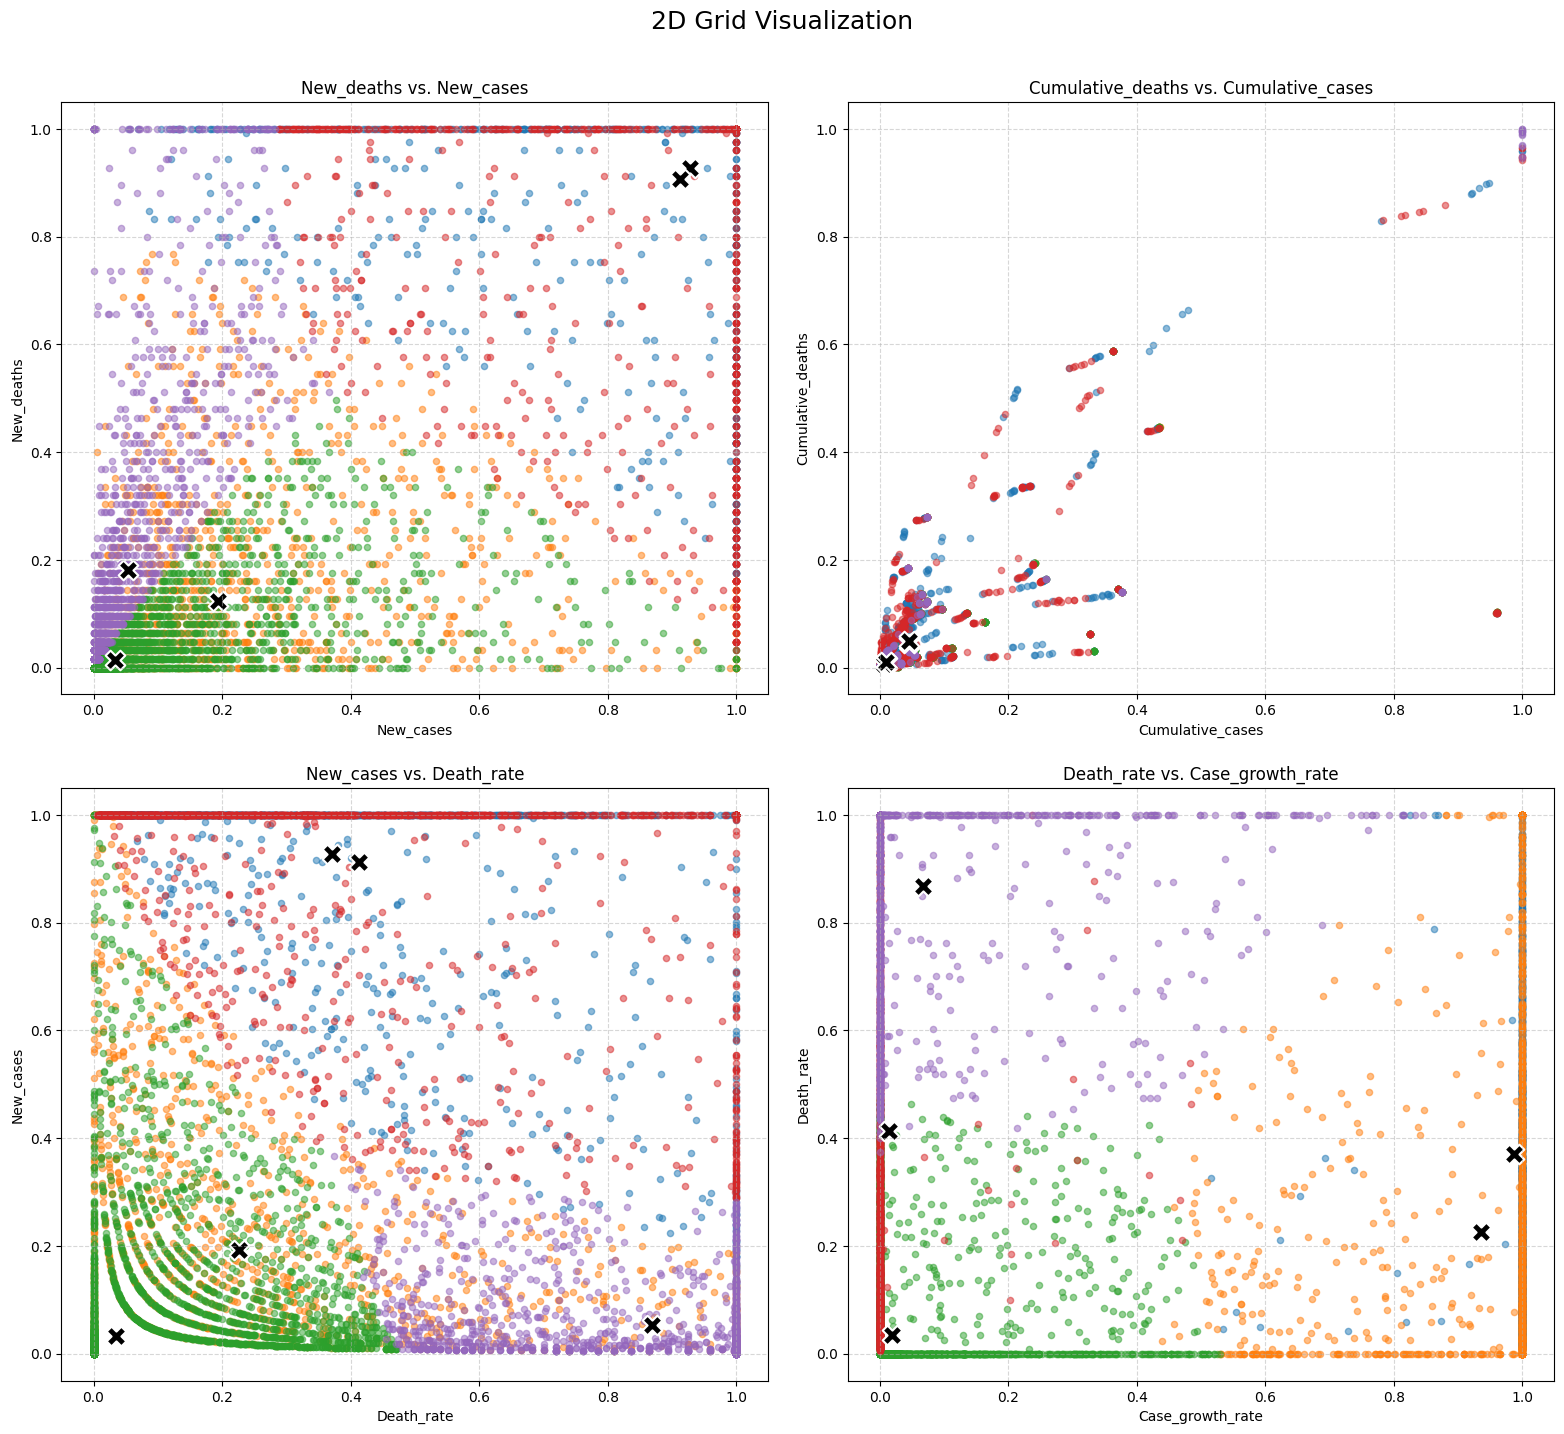

In [14]:
feature_pairs = [
    ('New_cases', 'New_deaths'),
    ('Cumulative_cases', 'Cumulative_deaths'),
    ('Death_rate', 'New_cases'),
    ('Case_growth_rate', 'Death_rate')
]

colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd']

fig, axes = plt.subplots(2, 2, figsize=(16, 14))
axes = axes.flatten()
legend_added = False

print("Generating Linear-Scale Visualization Grid...")

for plot_idx, (x_feat, y_feat) in enumerate(feature_pairs):
    ax = axes[plot_idx]

    for i in range(c):
        cluster_data = monthly_df[monthly_df['Cluster'] == i]
        ax.scatter(
            cluster_data[x_feat],
            cluster_data[y_feat],
            c=colors[i],
            label=f'Cluster {i}',
            alpha=0.5,
            s=20
        )
        
    ax.scatter(
        centers[x_feat],
        centers[y_feat],
        c='black',
        marker='X',
        s=200,
        label='Cluster Centers',
        edgecolor='white',
        linewidth=1.5
    )
    
    ax.set_xlabel(x_feat)
    ax.set_ylabel(y_feat)
    ax.set_title(f'{y_feat} vs. {x_feat}')
    ax.grid(True, linestyle='--', alpha=0.5)


plt.tight_layout(pad=2.0)
plt.suptitle('2D Grid Visualization', fontsize=18, y=1.03)
plt.savefig("fcm_clusters_2d_grid.png", dpi=300, bbox_inches='tight')
plt.show()
